In [1]:
import copy
import torch

import ltn
import numpy as np
from dataset import DataLoader, get_mnist_dataset_for_digits_addition
from logic import Stable_AND
from models import LogitsToPredicate, SingleDigitClassifier
from train import train_logic, pretrain_then_train_logic
import seaborn as sns
import torch.functional as F

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns
sns.set()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




In [2]:
train_set, test_set = get_mnist_dataset_for_digits_addition()
train_loader = DataLoader(train_set, 32, shuffle=True)
test_loader = DataLoader(test_set, 32, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 7.22MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 324kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.98MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.50MB/s]


In [3]:
And = ltn.Connective(Stable_AND())
# we use relaxed aggregators: see paper for details
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")

In [31]:
def plot_dists(val_dict, color="C0", xlabel=None, stat="frequency", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in val_dict.keys():
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig


def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        if "batch_norm" in name or "bn" in name:
            continue
        
        key_name = f"{' '.join(name.split('.')[2:])}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()


def visualize_gradients(model, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = train_loader
    operand_images, sum_label, _ = next(iter(small_loader))
    operand_images, sum_label = operand_images.to(device), sum_label.to(device)
    images_x = ltn.Variable("x", operand_images[:, 0])
    images_y = ltn.Variable("y", operand_images[:, 1])
    labels_z = ltn.Variable("z", sum_label)
    d_1 = ltn.Variable("d_1", torch.tensor(range(10)))
    d_2 = ltn.Variable("d_2", torch.tensor(range(10)))

    sat_agg = Forall(
        ltn.diag(images_x, images_y, labels_z),
        Exists(
            vars=[d_1, d_2],
            formula=And(model(images_x, d_1), model(images_y, d_2)),
            cond_vars=[d_1, d_2, labels_z],
            cond_fn=lambda d1, d2, z: torch.eq(d1.value + d2.value, z.value),
        ),
    ).value

    model.zero_grad()

    loss = 1.0 - sat_agg
    loss.backward()
    grads = {}
    for name, params in model.named_parameters():
        if "weight" in name and "batch_norm" not in name and "bn" not in name:
            key_name = f"{' '.join(name.split('.')[2:])}"
            grads[key_name] = params.grad.view(-1).cpu().clone().numpy()
    model.zero_grad()

    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in grads.keys():
            print(f"{key} - Variance: {np.var(grads[key])}")

def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = train_loader
    operand_images, sum_label, _ = next(iter(small_loader))
    operand_images, sum_label = operand_images.to(device), sum_label.to(device)

    operand_images = operand_images.flatten(start_dim=0, end_dim=1)

    # Pass one batch through the network, and calculate the gradients for the weights
    x = operand_images
    activations = {}
    with torch.no_grad():
        i = 0

        for conv in model.model.logits_model.mnistconv.conv_layers:
            x = model.model.logits_model.mnistconv.relu(conv(x))
            activations[f"conv_layer_{i}"] = x.view(-1).detach().cpu().numpy()
            x = model.model.logits_model.mnistconv.maxpool(x)
            i += 1

        x = torch.flatten(x, start_dim=1)
        for i in range(len(model.model.logits_model.mnistconv.linear_layers)):
            x = model.model.logits_model.mnistconv.tanh(model.model.logits_model.mnistconv.batch_norm_layers[i](model.model.logits_model.mnistconv.linear_layers[i](x)))
            activations[f"linear_layer_{i}"] = x.view(-1).detach().cpu().numpy()
            i += 1

        for i in range(len(model.model.logits_model.linear_layers) - 1):
            x = model.model.logits_model.tanh(model.model.logits_model.batch_norm_layers[i](model.model.logits_model.linear_layers[i](x)))
            activations[f"linear_layer_{i + 1}"] = x.view(-1).detach().cpu().numpy()
            i += 1
            
        x = model.model.logits_model.linear_layers[-1](x)
        activations["logits"] = x.view(-1).detach().cpu().numpy()

    

    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in activations.keys():
            print(f"{key} - Variance: {np.var(activations[key])}")

In [ ]:
i = 0

converging_models = []
non_converging_models = []

while True:
    if torch.cuda.is_available():
        torch.cuda.manual_seed(i)
        torch.cuda.manual_seed_all(i)

    torch.manual_seed(i)
    np.random.seed(i)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


    train_set, test_set = get_mnist_dataset_for_digits_addition()

    # create train and test loader
    train_loader = DataLoader(train_set, 32, shuffle=True)
    test_loader = DataLoader(test_set, 32, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    And = ltn.Connective(Stable_AND())
    # we use relaxed aggregators: see paper for details
    Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
    Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")

    cnn_s_d = SingleDigitClassifier().to(device)
    Digit_s_d = ltn.Predicate(LogitsToPredicate(cnn_s_d)).to(device)

    model_copy = copy.deepcopy(Digit_s_d)

    optimizer = torch.optim.Adam(Digit_s_d.parameters(), lr=0.001)
    metrics_prl = train_logic(
        Digit_s_d,
        optimizer,
        train_loader,
        test_loader,
        And,
        Exists,
        Forall,
        n_epochs=1,
        verbose=True,
    )

    if metrics_prl['test_accuracy_sum'][-1] > 0.5:
        print(f"Model {i} converged with test accuracy: {metrics_prl['test_accuracy_sum'][-1]}")
        converging_models.append(model_copy)
    else:
        print(f"Model {i} did not converge with test accuracy: {metrics_prl['test_accuracy_sum'][-1]}")
        non_converging_models.append(model_copy)

    if len(converging_models) >= 10 and len(non_converging_models) >= 10:
        break

    i += 1

    



Epoch 01 | Train Sat: 0.342 | Train Loss: 0.6580 | Train Sum Acc: 91.18% | Test Sat: 0.384 | Test Loss: 0.6156 | Test Sum Acc: 96.38% | Test Digit Acc: 98.18%
Model 0 converged with test accuracy: 0.9637739062309265
Epoch 01 | Train Sat: 0.153 | Train Loss: 0.8474 | Train Sum Acc: 45.16% | Test Sat: 0.166 | Test Loss: 0.8340 | Test Sum Acc: 45.80% | Test Digit Acc: 0.18%
Model 1 did not converge with test accuracy: 0.45800158381462097
Epoch 01 | Train Sat: 0.344 | Train Loss: 0.6562 | Train Sum Acc: 91.81% | Test Sat: 0.383 | Test Loss: 0.6167 | Test Sum Acc: 95.96% | Test Digit Acc: 97.97%
Model 2 converged with test accuracy: 0.9595939517021179
Epoch 01 | Train Sat: 0.344 | Train Loss: 0.6555 | Train Sum Acc: 92.04% | Test Sat: 0.384 | Test Loss: 0.6164 | Test Sum Acc: 96.22% | Test Digit Acc: 98.09%
Model 3 converged with test accuracy: 0.9621815085411072
Epoch 01 | Train Sat: 0.342 | Train Loss: 0.6582 | Train Sum Acc: 90.84% | Test Sat: 0.383 | Test Loss: 0.6166 | Test Sum Acc: 96

In [66]:
def plot_multiple_dists(val_dicts, color="C0", xlabel=None, stat="probability", use_kde=True):
    columns = len(val_dicts[0])
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in val_dicts[0].keys():
        for i, val_dict in enumerate(val_dicts):
            key_ax = ax[fig_index%columns]
            sns.kdeplot(val_dict[key], ax=key_ax)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

def visualize_multiple_weight_distributions(models, color="C0"):
    items = []
    for model in models:
        weights = {}
        for name, param in model.named_parameters():
            if name.endswith(".bias"):
                continue
            if "batch_norm" in name or "bn" in name:
                continue
            
            key_name = f"{' '.join(name.split('.')[2:])}"
            weights[key_name] = param.detach().view(-1).cpu().numpy()
        items.append(weights)
        

    ## Plotting
    fig = plot_multiple_dists(items, color=color, xlabel="Weight vals", )
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

def visualize_multiple_gradients(models, color="C0", print_variance=False):
    items = []
    for model in models:
        model.eval()
        small_loader = train_loader
        operand_images, sum_label, _ = next(iter(small_loader))
        operand_images, sum_label = operand_images.to(device), sum_label.to(device)
        images_x = ltn.Variable("x", operand_images[:, 0])
        images_y = ltn.Variable("y", operand_images[:, 1])
        labels_z = ltn.Variable("z", sum_label)
        d_1 = ltn.Variable("d_1", torch.tensor(range(10)))
        d_2 = ltn.Variable("d_2", torch.tensor(range(10)))

        sat_agg = Forall(
            ltn.diag(images_x, images_y, labels_z),
            Exists(
                vars=[d_1, d_2],
                formula=And(model(images_x, d_1), model(images_y, d_2)),
                cond_vars=[d_1, d_2, labels_z],
                cond_fn=lambda d1, d2, z: torch.eq(d1.value + d2.value, z.value),
            ),
        ).value

        model.zero_grad()

        loss = 1.0 - sat_agg
        loss.backward()
        grads = {}
        for name, params in model.named_parameters():
            if "weight" in name and "batch_norm" not in name and "bn" not in name:
                key_name = f"{' '.join(name.split('.')[2:])}"
                grads[key_name] = params.grad.view(-1).cpu().clone().numpy()
        model.zero_grad()
        
        items.append(grads)
    
    ## Plotting
    fig = plot_multiple_dists(items, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

def visualize_multiple_activations(models, color="C0", print_variance=False):
    items = []
    for model in models:
        model.eval()
        small_loader = train_loader
        operand_images, sum_label, _ = next(iter(small_loader))
        operand_images, sum_label = operand_images.to(device), sum_label.to(device)

        operand_images = operand_images.flatten(start_dim=0, end_dim=1)

        # Pass one batch through the network, and calculate the gradients for the weights
        x = operand_images
        activations = {}
        with torch.no_grad():
            i = 0

            for conv in model.model.logits_model.mnistconv.conv_layers:
                x = model.model.logits_model.mnistconv.relu(conv(x))
                activations[f"conv_layer_{i}"] = x.view(-1).detach().cpu().numpy()
                x = model.model.logits_model.mnistconv.maxpool(x)
                i += 1

            x = torch.flatten(x, start_dim=1)
            for i in range(len(model.model.logits_model.mnistconv.linear_layers)):
                x = model.model.logits_model.mnistconv.tanh(model.model.logits_model.mnistconv.batch_norm_layers[i](model.model.logits_model.mnistconv.linear_layers[i](x)))
                activations[f"linear_layer_{i}"] = x.view(-1).detach().cpu().numpy()
                i += 1

            for i in range(len(model.model.logits_model.linear_layers) - 1):
                x = model.model.logits_model.tanh(model.model.logits_model.batch_norm_layers[i](model.model.logits_model.linear_layers[i](x)))
                activations[f"linear_layer_{i + 1}"] = x.view(-1).detach().cpu().numpy()
                i += 1
                
            x = model.model.logits_model.linear_layers[-1](x)
            activations["logits"] = x.view(-1).detach().cpu().numpy()

        items.append(activations)

    ## Plotting
    fig = plot_multiple_dists(items, color=color, stat="probability", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

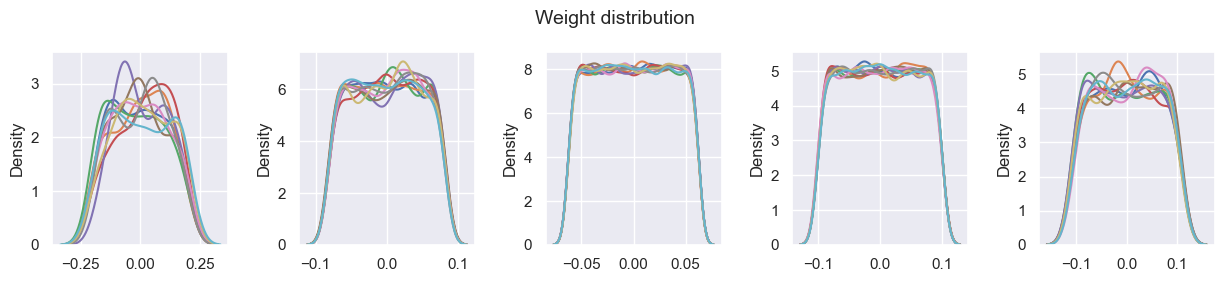

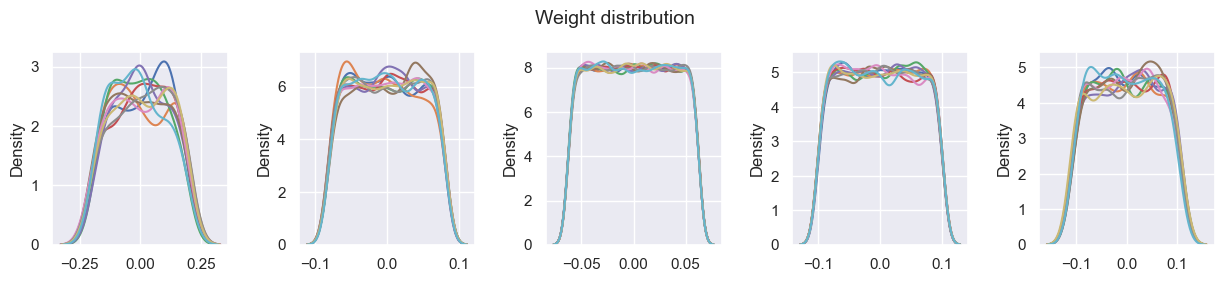

In [67]:
visualize_multiple_weight_distributions(converging_models[0:10], color="C0")
visualize_multiple_weight_distributions(non_converging_models[0:10], color="C0")


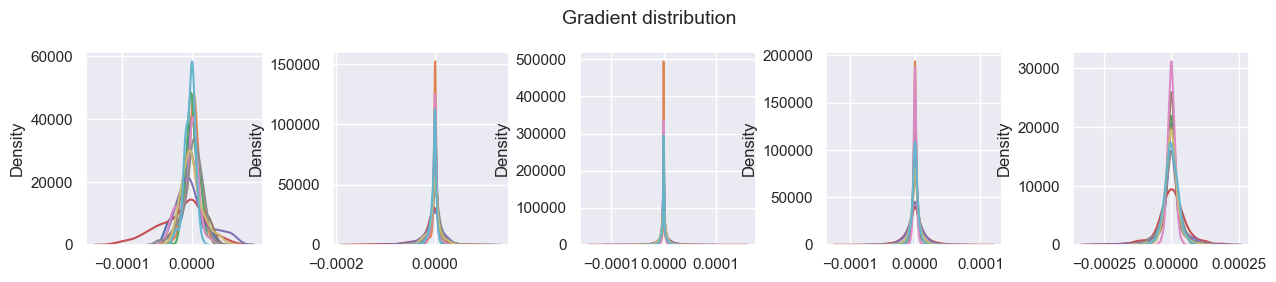

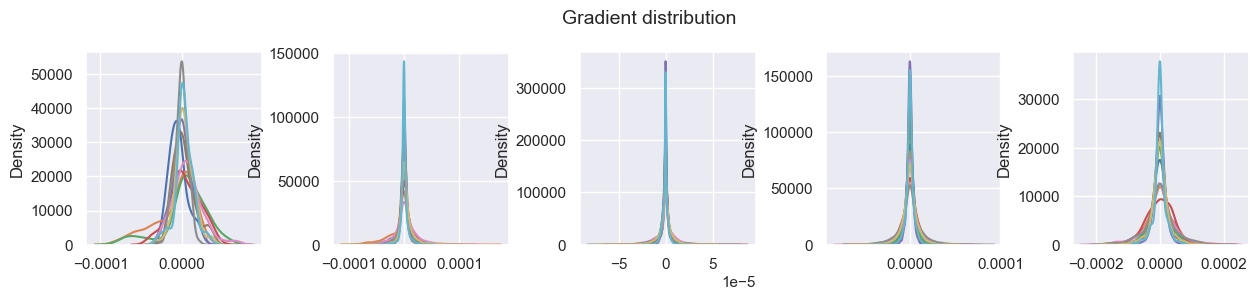

In [ ]:
visualize_multiple_gradients(converging_models[0:10], color="C0")
visualize_multiple_gradients(non_converging_models[0:10], color="C0")

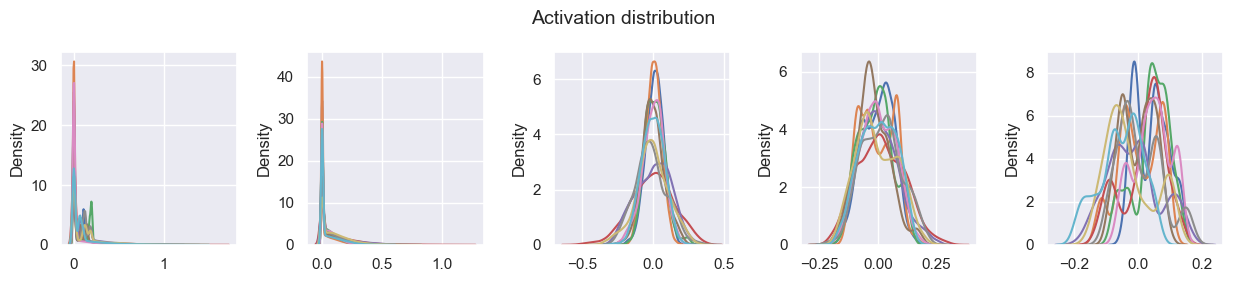

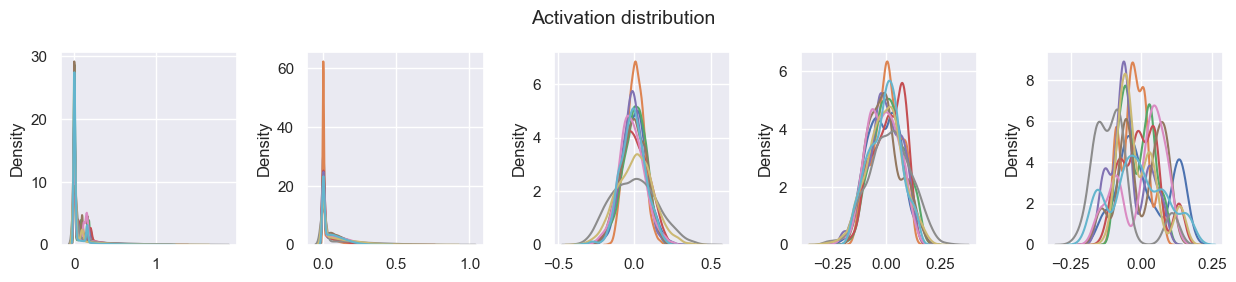

In [69]:
visualize_multiple_activations(converging_models[0:10], color="C0")
visualize_multiple_activations(non_converging_models[0:10], color="C0")